In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest, chi2
import matplotlib.pyplot as plt
import seaborn as sns
from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize
import nltk
import re
import spacy
from nltk.corpus import stopwords
from nltk import ngrams
from wordcloud import WordCloud
from scipy.stats import pearsonr
from tqdm import tqdm
import nltk
import spacy
import os

In [2]:
tqdm.pandas()

df = pd.read_csv('../data/processed/data_toxic_cleaned.csv')

df

,message,label
0,"Hola, dale actualizar a la pagina o la tecla F5",0
1,Ningún mujer te va a dejar por un error. porqu...,1
2,"Entonces, si está haciendo una correspondencia...",0
3,victoria con el pelito corto me voy a matar,1
4,@LoloPeniche Periodista!!!!!\nEs una puta verd...,1
...,...,...
482191,"Puedo cambiarle los colores: rojo, azul claro ...",0
482192,Argentina: *apoya a la Alemania Nazi en la gue...,1
482193,No dale no hay problema muchísimas gracias no ...,0
482194,"Mi nombre es ""onassis amaya cc 84083683",0


In [3]:
# Configuración de stopwords
nltk.download('stopwords')
STOP_WORDS = set(stopwords.words('spanish'))
STOP_WORDS.update(['q', 'si', 'ser', 'va'])

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Jhon\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
# Cargar el modelo de spaCy para español
nlp = spacy.load("es_core_news_sm", disable=["ner", "parser", "tagger"])


C:\Users\Jhon\anaconda3\envs\facef\lib\site-packages\torch\__init__.py:614: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at ..\torch\csrc\tensor\python_tensor.cpp:453.)
  _C._set_default_tensor_type(t)


In [5]:
def lemmatize_text(text):
    """
    Lematiza un texto individual, preservando tokens especiales como '[MENCION]' y '[NUMERO]',
    incluso cuando están pegados a otras palabras.
    """
    if pd.isna(text):
        return ""

    special_tokens = ['[MENCION]', '[NUMERO]']

    for token in special_tokens:
        text = re.sub(rf'({re.escape(token)})(\S)', r'\1 \2', text)
        text = re.sub(rf'(\S)({re.escape(token)})', r'\1 \2', text)

    tokens = re.findall(r'\[MENCION\]|\[NUMERO\]|\S+', text)

    lemmatized_tokens = []
    for token in tokens:
        if token in special_tokens:
            lemmatized_tokens.append(token)
        else:
            doc = nlp(token)
            lemmatized_tokens.append(doc[0].lemma_)

    return " ".join(lemmatized_tokens)

def preprocess_text(text):
    """
    Preprocesa el texto: convierte a minúsculas, elimina URLs, elimina caracteres especiales y stopwords,
    reemplaza las menciones (@username) con un token estándar, mantiene los hashtags,
    elimina menciones duplicadas y reemplaza números completos con [NUMERO].
    """
    # Convierte a minúsculas
    text = text.lower()
    
    # Elimina URLs
    text = re.sub(r'http\S+|www\.\S+', '', text)
    
    # Reemplaza las menciones (@username) con [MENCION]
    text = re.sub(r'@\w+', '[MENCION]', text)
    
    # Elimina el símbolo '#' pero mantiene el texto del hashtag
    text = re.sub(r'#(\w+)', r'\1', text)
    
    # Reemplaza números completos con [NUMERO]
    text = re.sub(r'\b\d+\b', '', text)
    
    # Elimina caracteres especiales, incluyendo el guion bajo, pero manteniendo [MENCION] y [NUMERO]
    text = re.sub(r'[^\w\s\[MENCION\]\[NUMERO\]#]|_', '', text)
    
    # Divide el texto en palabras y elimina las stopwords
    words = text.split()
    words = [word for word in words if word not in STOP_WORDS]
    
    # Elimina menciones duplicadas
    mention_found = False
    filtered_words = []
    for word in words:
        if word == '[MENCION]':
            if not mention_found:
                filtered_words.append(word)
                mention_found = True
        else:
            filtered_words.append(word)
    
    return ' '.join(filtered_words).strip()

In [6]:
# Aplicar preprocesamiento y lematización
print('Preprocesando texto...')
df['processed_message'] = df['message'].progress_apply(preprocess_text)

print('Lematizando texto...')
df['lemmatized_message'] = df['processed_message'].progress_apply(lemmatize_text)


Preprocesando texto...


100%|███████████████████████████████████████████████████████████████████████| 482196/482196 [00:05<00:00, 83384.03it/s]


Lematizando texto...


100%|███████████████████████████████████████████████████████████████████████| 482196/482196 [1:06:47<00:00, 120.32it/s]


In [7]:
df = df.dropna(subset=['processed_message']).reset_index(drop=True)
# Guardar el DataFrame con el texto procesado y lematizado
output_path = '../data/processed/data_toxic_processed_lemmatized.csv'
os.makedirs(os.path.dirname(output_path), exist_ok=True)
df.to_csv(output_path, index=False)
print(f"DataFrame con texto procesado y lematizado guardado en: {output_path}")


DataFrame con texto procesado y lematizado guardado en: ../data/processed/data_toxic_processed_lemmatized.csv


In [52]:
# Cargar el dataset con texto procesado y lematizado
df = pd.read_csv('../data/processed/data_toxic_processed_lemmatized.csv')


In [55]:
import unicodedata

def eliminar_acentos(texto):
    """
    Elimina los acentos de un texto.
    
    Args:
    texto (str): El texto del cual se eliminarán los acentos.
    
    Returns:
    str: El texto sin acentos.
    """
    # Normalizamos el texto a su forma NFKD
    texto_normalizado = unicodedata.normalize('NFKD', texto)
    
    # Eliminamos todos los caracteres que no sean ASCII
    texto_sin_acentos = ''.join(c for c in texto_normalizado if not unicodedata.combining(c))
    
    return texto_sin_acentos

# Aplicar la función a la columna 'lemmatized_message' y sobrescribir la columna original
print("Eliminando acentos de la columna lematizada...")
df['lemmatized_message'] = df['lemmatized_message'].progress_apply(eliminar_acentos)

# Mostrar algunas filas para verificar
print(df['lemmatized_message'].head())
output_path = '../data/processed/data_toxic_processed_lemmatized.csv'
os.makedirs(os.path.dirname(output_path), exist_ok=True)
df.to_csv(output_path, index=False)
print(f"DataFrame con texto procesado y lematizado guardado en: {output_path}")

Eliminando acentos de la columna lematizada...


100%|████████████████████████████████████████████████████████████████| 482086/482086 [00:03<00:00, 156244.38it/s]


0               hola dalar actualizar pagina teclar f5
1    ninguno mujer dejar error humano alguno moment...
2    entonces hacer correspondencia r como dibujar ...
3                      victoria pelitir corto ir matar
4           [MENCION] periodista puta verdulera hdsptm
Name: lemmatized_message, dtype: object
DataFrame con texto procesado y lematizado guardado en: ../data/processed/data_toxic_processed_lemmatized.csv


In [53]:
df

,message,label,processed_message,lemmatized_message,processed_length,processed_word_count
0,"Hola, dale actualizar a la pagina o la tecla F5",0,hola dale actualizar pagina tecla f5,hola dalar actualizar pagina teclar f5,36.0,6.0
1,Ningún mujer te va a dejar por un error. porqu...,1,ningún mujer dejar error humanos algún momento...,ninguno mujer dejar error humano alguno moment...,104.0,15.0
2,"Entonces, si está haciendo una correspondencia...",0,entonces haciendo correspondencia r cómo dibuj...,entonces hacer correspondencia r cómo dibujar ...,91.0,15.0
3,victoria con el pelito corto me voy a matar,1,victoria pelito corto voy matar,victoria pelitir corto ir matar,31.0,5.0
4,@LoloPeniche Periodista!!!!!\nEs una puta verd...,1,[MENCION] periodista puta verdulera hdsptm,[MENCION] periodista puta verdulera hdsptm,42.0,5.0
...,...,...,...,...,...,...
482081,"Puedo cambiarle los colores: rojo, azul claro ...",0,puedo cambiarle colores rojo azul claro multic...,poder cambiar él color rojo azul claro multico...,86.0,12.0
482082,Argentina: *apoya a la Alemania Nazi en la gue...,1,argentina apoya alemania nazi guerra alemania ...,argentina apoyar alemania nazi guerra alemania...,102.0,13.0
482083,No dale no hay problema muchísimas gracias no ...,0,dale problema muchísimas gracias sabía dato en...,dalar problema muchísimas gracias saber dato e...,125.0,17.0
482084,"Mi nombre es ""onassis amaya cc 84083683",0,nombre onassis amaya cc,nombre onassis amaya cc,23.0,4.0


In [66]:
palabras_ofensivas = [
    "asesinato", "asno", "bastardo", "bollera", "cabron", "caca", "chupada", 
    "chupapollas", "chupeton", "concha", "concha de tu madre", "cono", 
    "coprofagia", "culo", "drogas", "esperma", "fiesta de salchichas", "facista", "fascista", "estupido", "hdsp"
    "follador", "follar", "gilipichis", "gilipollas", "gilipolla", "hacer paja", 
    "haciendo el amor", "heroina", "hija de puta", "hijaputa", "hijo de puta", 
    "hijoputa", "idiota", "imbecil", "infierno", "jilipollas", "kapullo", 
    "lameculos", "maciza", "macizorra", "maldito", "mamada", "marica", 
    "maricon", "mariconazo", "martillo", "mierda", "nazi", "orina", "pedo", 
    "pendejo", "pervertido", "pezon", "pinche", "pis", "prostituta", "puta", 
    "racista", "ramera", "sadico", "semen", "sexo", "sexo oral", "soplagaitas", 
    "soplapollas", "tetas grandes", "tia buena", "travesti", "trio", "verga", 
    "vete a la mierda", "vulva"
]

def contar_palabras_ofensivas(texto):
    texto = texto.lower()
    contador = sum(1 for palabra in palabras_ofensivas if re.search(r'\b' + re.escape(palabra) + r'\b', texto))
    return contador


In [67]:
df = df.dropna(subset=['processed_message']).reset_index(drop=True)

# Características basadas en longitud y mayúsculas
df['processed_length'] = df['processed_message'].str.len()
df['processed_word_count'] = df['processed_message'].str.split().str.len()
df['processed_avg_word_length'] = df['processed_message'].apply(lambda x: np.mean([len(word) for word in x.split()]) if len(x.split()) > 0 else 0)

#df['has_mention'] = df['mention_count'] > 0

# Característica de mayúsculas (usando el texto original)
df['uppercase_ratio'] = df['message'].apply(lambda x: sum(1 for c in x if c.isupper()) / len(x) if len(x) > 0 else 0)

# Característica de tokens especiales en el texto procesado
df['mencion_count'] = df['processed_message'].str.count('\[MENCION\]')
df['numero_count'] = df['processed_message'].str.count('\[NUMERO\]')


# Aplicar la función a la columna 'message' (texto original)
df['ofensivas_count'] = df['lemmatized_message'].apply(contar_palabras_ofensivas)


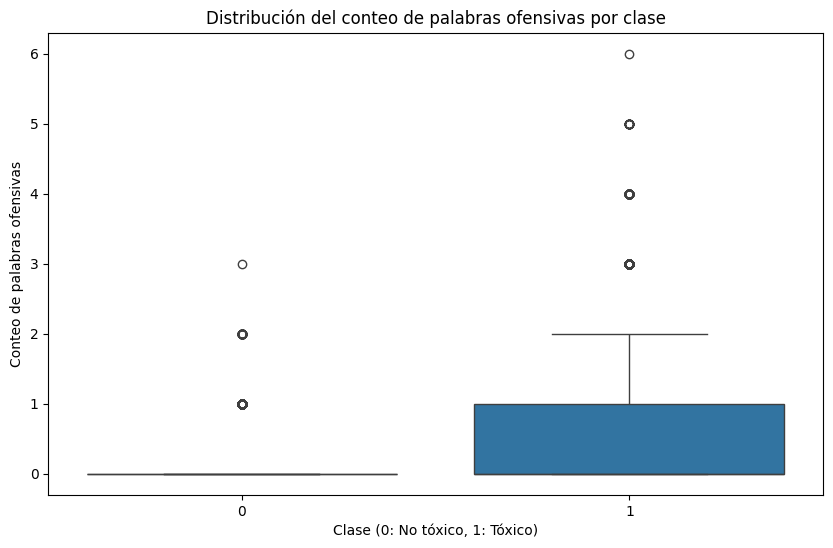

Correlación entre conteo de palabras ofensivas y toxicidad: 0.4289


In [68]:
# Visualizar la distribución de esta nueva característica
plt.figure(figsize=(10, 6))
sns.boxplot(x='label', y='ofensivas_count', data=df)
plt.title('Distribución del conteo de palabras ofensivas por clase')
plt.xlabel('Clase (0: No tóxico, 1: Tóxico)')
plt.ylabel('Conteo de palabras ofensivas')
plt.show()

# Calcular la correlación con la etiqueta
correlacion = df['ofensivas_count'].corr(df['label'])
print(f"Correlación entre conteo de palabras ofensivas y toxicidad: {correlacion:.4f}")

# Añadir esta nueva característica al conjunto de características
columns_to_save.append('conteo_palabras_ofensivas')


In [46]:
# Características basadas en n-gramas (usando TF-IDF)
print("Generando características de TF-IDF para n-gramas...")
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 3), max_features=1000)
tfidf_matrix = tfidf_vectorizer.fit_transform(df['lemmatized_message'])

# Convertir la matriz TF-IDF a un DataFrame
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf_vectorizer.get_feature_names_out())

# Combinar las características TF-IDF con el DataFrame original
df = pd.concat([df, tfidf_df], axis=1)

# Visualización de características numéricas básicas
numeric_features = ['processed_length', 'processed_word_count', 'processed_avg_word_length', 
                     'uppercase_ratio', 'mencion_count']

Generando características de TF-IDF para n-gramas...


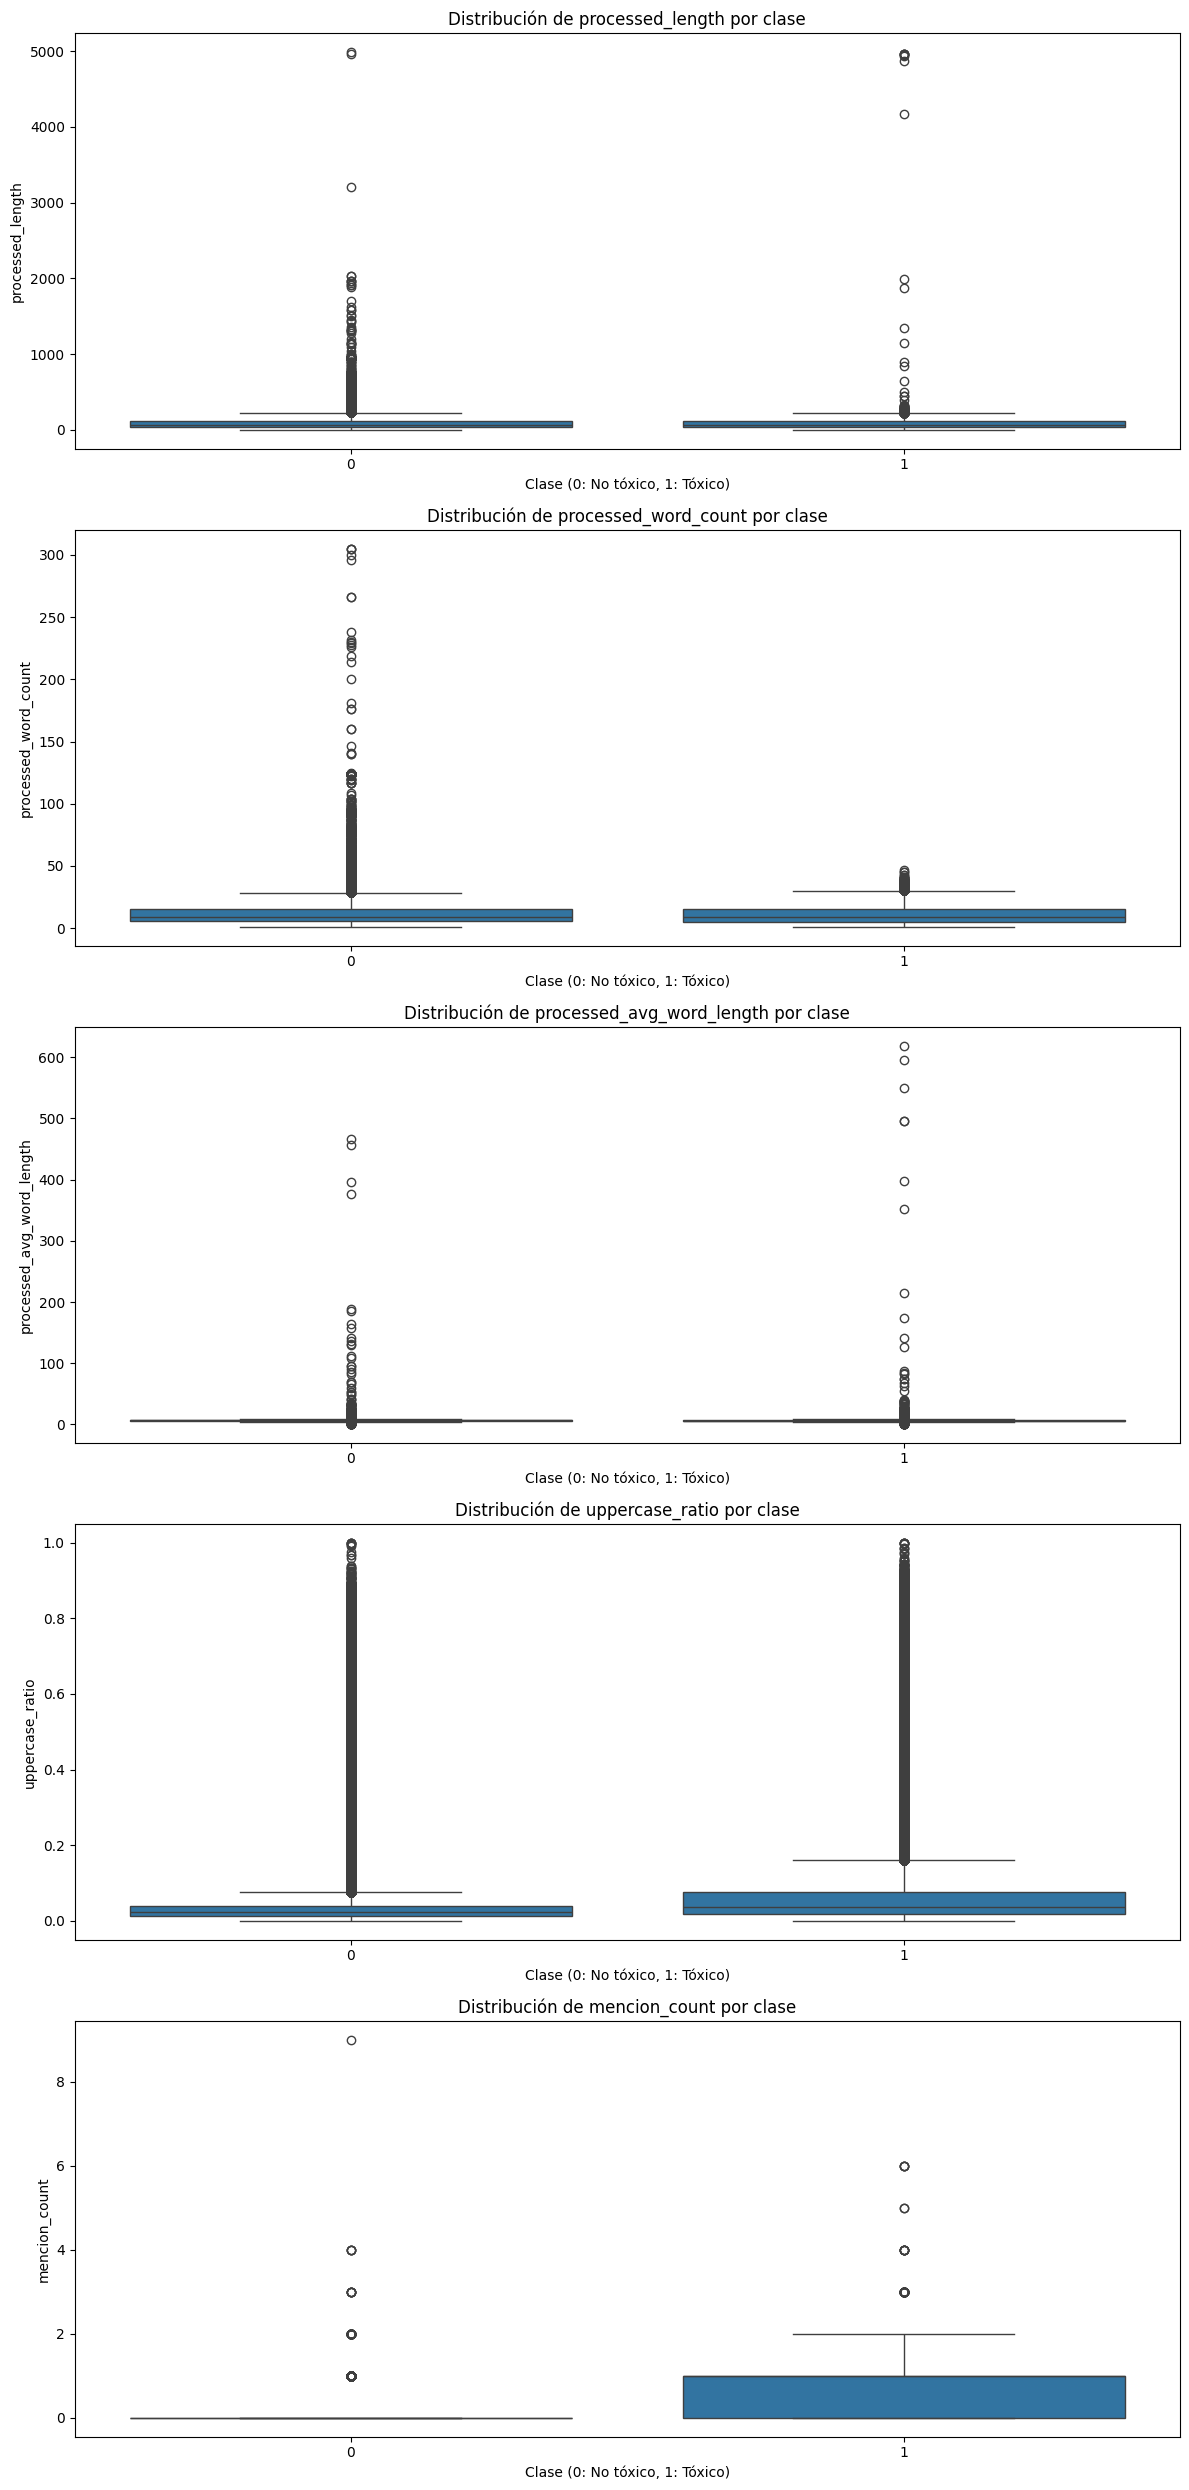

In [47]:
fig, axes = plt.subplots(len(numeric_features), 1, figsize=(12, 5*len(numeric_features)))
for i, feature in enumerate(numeric_features):
    sns.boxplot(x='label', y=feature, data=df, ax=axes[i])
    axes[i].set_title(f'Distribución de {feature} por clase')
    axes[i].set_xlabel('Clase (0: No tóxico, 1: Tóxico)')

plt.tight_layout()
plt.show()



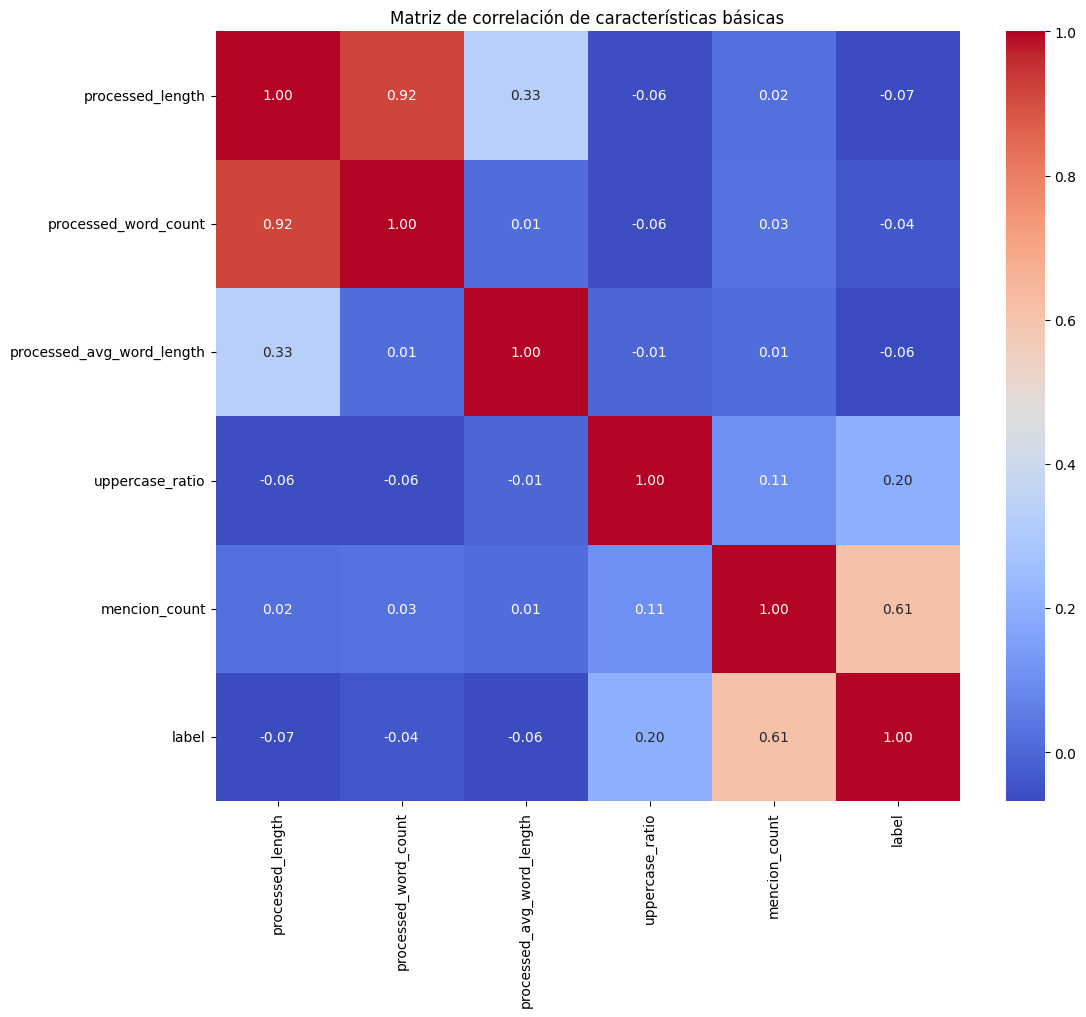

In [48]:
# Análisis de correlación de características básicas
correlation_matrix = df[numeric_features + ['label']].corr()
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Matriz de correlación de características básicas')
plt.show()

In [69]:

columns_to_save = ['message', 'processed_message', 'lemmatized_message', 'label', 
                   'processed_length', 'processed_avg_word_length', 
                   'uppercase_ratio', 'mencion_count', "ofensivas_count"]

# Crear un nuevo DataFrame con las columnas seleccionadas
df_to_save = df[columns_to_save]

# Guardar el DataFrame con las nuevas características
output_path = '../data/processed/data_toxic_features.csv'
df_to_save.to_csv(output_path, index=False)
print(f"DataFrame con características guardado en: {output_path}")

print("Feature engineering completado.")

DataFrame con características guardado en: ../data/processed/data_toxic_features.csv
Feature engineering completado.


## Conclusiones del Análisis de Características

El análisis de correlación revela que `mencion_count` es el predictor más fuerte de toxicidad (0.61), seguido por `uppercase_ratio` (0.20). Las características de longitud (`processed_length` y `processed_word_count`) están altamente correlacionadas entre sí (0.92), sugiriendo redundancia. 

La correlación entre el conteo de palabras ofensivas y la toxicidad es de 0.4291, lo que sugiere una correlación positiva moderada.

